# Push T Task with PI Model

This notebook demonstrates training and evaluating the Pi model on the PushT task.


In [2]:
from pathlib import Path
import torch
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.configs.types import FeatureType
from lerobot.datasets.utils import dataset_to_policy_features

## 1. Load PushT Dataset

First, let's load the PushT dataset and explore its properties.


In [ ]:
# Load dataset metadata
repo_id = "lerobot/pusht"
ds_meta = LeRobotDatasetMetadata(repo_id)
print(ds_meta)

for key, value in ds_meta.features.items():
    print(f"{key}: {value.get('dtype', 'unknown')}, {value.get('shape', 'unknown')}")



In [ ]:
# Load the full dataset
dataset = LeRobotDataset(repo_id)
print(dataset)
print(f"Number of episodes: {dataset.num_episodes}")
print(f"Number of frames: {dataset.num_frames}")
print(f"FPS: {dataset.fps}")

for key, value in dataset.meta.episodes.features.items():
    print(f"{key}: {value}")


In [ ]:
policy_features = dataset_to_policy_features(dataset.meta.features)
for key, value in policy_features.items():
    print(f"{key}: {value.type, value.shape}")


## 2. Visualize Sample Episode

Let's visualize a sample episode from the dataset to understand what the task looks like.

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

# Get frames from first episode
episode_index = 0
from_idx = dataset.meta.episodes["dataset_from_index"][episode_index]
to_idx = dataset.meta.episodes["dataset_to_index"][episode_index]

camera_key = dataset.meta.camera_keys[0]
frames = [dataset[idx][camera_key] for idx in range(from_idx, to_idx)] 

plt.figure(figsize=(8, 8))
for frame_idx in range(len(frames)):
    image = frames[frame_idx].permute(1, 2, 0).cpu().numpy()
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Episode {episode_index}, Step: {frame_idx}')
    display(plt.gcf())
    time.sleep(0.01)
plt.close()


## 3. Initialize Pi Model

Now we'll load the Pi model for training on this task.

In [ ]:
# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. Pi requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

In [ ]:
# Set up output directory
pi_model_name = "pi05"
output_directory = Path(f"outputs/train/pusht_{pi_model_name}")
output_directory.mkdir(parents=True, exist_ok=True)

In [ ]:
# Prepare input/output features for the policy
dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

print("Input features:", list(input_features.keys()))
print("Output features:", list(output_features.keys()))


In [ ]:
from lerobot.policies.pi05.configuration_pi05 import PI05Config
# Initialize SmolVLA configuration and policy
# Using pretrained SmolVLA checkpoint

cfg = PI05Config(
    input_features=input_features,
    output_features=output_features,
    device="cuda",
    #paligemma_variant="gemma_300m",
    #action_expert_variant="gemma_300m",
    pretrained_path="lerobot/pi05_base",
)

print("VLA Config created successfully")

In [ ]:
# Instantiate the policy
from lerobot.policies.pi05.modeling_pi05 import PI05Policy
from lerobot.policies.factory import make_pre_post_processors
policy = PI05Policy(cfg)
policy.train()
policy.to(device)

# Create pre/post processors
preprocessor, postprocessor = make_pre_post_processors(cfg, dataset_stats=dataset_metadata.stats)

print(f"Policy loaded and moved to {device}")
print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")


## 4. Prepare Dataset with Delta Timestamps

PI uses temporal information, so we need to configure delta timestamps.


In [ ]:
# Another policy-dataset interaction is with the delta_timestamps. Each policy expects a given number frames
# which can differ for inputs, outputs and rewards (if there are some).
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}

In [ ]:
print("Delta timestamps configuration:")
for key, deltas in delta_timestamps.items():
    print(f"  {key}: {deltas}")


In [ ]:
# Load dataset with temporal configuration
dataset = LeRobotDataset(
    "lerobot/pusht",
    delta_timestamps=delta_timestamps,
)

print(f"Dataset loaded with {dataset.num_frames} frames")


## 5. Train SmolVLA Policy

Now we'll train the SmolVLA model on the PushT dataset.


In [ ]:
# Training configuration
training_steps = 20000
batch_size = 8  # SmolVLA may need smaller batch size due to memory

# Set up optimizer and scheduler
optimizer_config = {
    "lr":  2.5e-5,
    "weight_decay": 1e-10,
    "betas": (0.9, 0.95),
    "eps": 1e-08
}

scheduler_config = {
    "num_warmup_steps": 1000,
    "num_decay_steps": 30000,
    "peak_lr": 2.5e-5,
    "decay_lr": 2.5e-06
}

grad_clip_norm = 1.0

# Create AdamW optimizer
optimizer = torch.optim.AdamW(
    policy.parameters(),
    lr=optimizer_config["lr"],
    weight_decay=optimizer_config["weight_decay"],
    betas=optimizer_config["betas"],
    eps=optimizer_config["eps"]
)

# Create cosine decay with warmup scheduler
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_decay_steps, peak_lr, decay_lr):
    """
    Create a learning rate scheduler with linear warmup and cosine decay.
    
    Args:
        optimizer: PyTorch optimizer
        num_warmup_steps: Number of steps for linear warmup
        peak_lr: Peak learning rate after warmup
        num_decay_steps: Total number of steps for cosine decay
        decay_lr: Minimum learning rate at the end of decay
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            # Linear warmup
            return float(current_step) / float(max(1, num_warmup_steps))
        else:
            # Cosine decay
            progress = float(current_step - num_warmup_steps) / float(max(1, num_decay_steps - num_warmup_steps))
            progress = min(progress, 1.0)
            cosine_decay = 0.5 * (1.0 + torch.cos(torch.tensor(progress * 3.14159265359))).item()
            return (decay_lr / peak_lr) + (1.0 - decay_lr / peak_lr) * cosine_decay
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=scheduler_config["num_warmup_steps"],
    num_decay_steps=scheduler_config["num_decay_steps"],
    peak_lr=scheduler_config["peak_lr"],
    decay_lr=scheduler_config["decay_lr"]
)

# Set up dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    drop_last=True,
)

print(f"Training configuration:")
print(f"  Steps: {training_steps}")
print(f"  Batch size: {batch_size}")
print(f"  Learning rate: {optimizer_config['lr']}")
print(f"  Weight decay: {optimizer_config['weight_decay']}")
print(f"  Betas: {optimizer_config['betas']}")
print(f"  Epsilon: {optimizer_config['eps']}")
print(f"  Gradient clip norm: {grad_clip_norm}")
print(f"  Warmup steps: {scheduler_config['num_warmup_steps']}")
print(f"  Decay steps: {scheduler_config['num_decay_steps']}")
print(f"  Peak LR: {scheduler_config['peak_lr']}")
print(f"  Decay LR: {scheduler_config['decay_lr']}")
print(f"  Batches per epoch: {len(dataloader)}")


In [ ]:
# Training loop
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io._video_deprecation_warning')

step = 0
done = False
epoch = 0
losses = []
learning_rates = []

print("Starting training...\n")
# Add this right after creating the scheduler in Cell 18
print(f"Initial LR after scheduler creation: {optimizer.param_groups[0]['lr']:.8f}")
print(f"Scheduler last_epoch: {scheduler.last_epoch}")

policy.train()

log_freq = 10

while not done:
    epoch += 1
    for batch in dataloader:
        # Preprocess batch
        batch = preprocessor(batch)
        
        # Forward pass
        loss, _ = policy.forward(batch)
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(policy.parameters(), max_norm=grad_clip_norm)
        
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())
        # Track metrics
        if step % log_freq == 0:
            avg_loss = sum(losses[-log_freq:]) / len(losses[-log_freq:])
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch}, Step {step:5d}: loss = {loss.item():.4f}, avg_loss = {avg_loss:.4f}, lr = {current_lr:.6f}")
            learning_rates.append(current_lr)
                
        step += 1
        if step >= training_steps:
            done = True
            break

print(f"\nTraining completed! Final loss: {losses[-1]:.4f}")


In [ ]:
# Plot training loss and learning rate
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot loss
ax1.plot(losses[200::200])
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Loss')
ax1.set_title('SmolVLA Training Loss on PushT')
ax1.grid(True, alpha=0.3)

# Plot learning rate schedule
ax2.plot(learning_rates, color='orange')
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Learning Rate')
ax2.set_title('Learning Rate Schedule (Warmup + Cosine Decay)')
ax2.grid(True, alpha=0.3)
ax2.axvline(x=scheduler_config['num_warmup_steps'], color='red', linestyle='--', label='End of Warmup')
ax2.set_yscale('log')  # Log scale for better visualization
ax2.legend()

plt.tight_layout()
plt.show()

## 6. Save Trained Model


In [ ]:
# Save the trained model
policy.save_pretrained(output_directory)
preprocessor.save_pretrained(output_directory)
postprocessor.save_pretrained(output_directory)

print(f"Model saved to {output_directory}")


## 7. Evaluate on PushT Environment

Now let's test the trained SmolVLA model in the PushT environment.


In [3]:
from lerobot.policies.pi05.modeling_pi05 import PI05Policy
from lerobot.policies.factory import make_pre_post_processors


# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. Pi requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

model_path = None
output_directory = '/home/xipengw/deeplearning/vla/lerobot/outputs/train/my_pi05_pusht/checkpoints/last/pretrained_model'
if False:
    model_path = "annarborace01/my-pi05-pusht"
else:
    model_path = output_directory


policy = PI05Policy.from_pretrained(model_path)
print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")
preprocessor, postprocessor = make_pre_post_processors(policy.config, pretrained_path=model_path)

policy.eval()
policy.to(device)

print(f"Model loaded from {model_path}")
print(f"Policy device: {next(policy.parameters()).device}")


Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
The PI05 model is a direct port of the OpenPI implementation. 
This implementation follows the original OpenPI structure for compatibility. 
Original implementation: https://github.com/Physical-Intelligence/openpi


Loading model from: /home/xipengw/deeplearning/vla/lerobot/outputs/train/my_pi05_pusht/checkpoints/last/pretrained_model
✓ Loaded state dict from model.safetensors
	Missing key(s) in state_dict: "model.paligemma_with_expert.paligemma.model.language_model.embed_tokens.weight". 
Number of trainable parameters: 3,616,757,520
Model loaded from /home/xipengw/deeplearning/vla/lerobot/outputs/train/my_pi05_pusht/checkpoints/last/pretrained_model
Policy device: cuda:0


In [4]:
# Create PushT environment
import gymnasium as gym
import numpy as np
from pathlib import Path

try:
    import gym_pusht
    env = gym.make("gym_pusht/PushT-v0", render_mode="rgb_array", obs_type="pixels_agent_pos")
    print("PushT environment created successfully")
except ImportError:
    print("Warning: gym_pusht not installed. Install with: pip install gym-pusht")
    env = None
except Exception as e:
    print(f"Error creating environment: {e}")
    env = None


PushT environment created successfully


In [5]:
import torch

# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. SmolVLA requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Reset the environment
observation, info = env.reset(seed=420)
# Reset the policy's internal queue at the start of each episode
policy.reset()

frames_for_video = []
max_steps = 1000
log_freq = 50
episode_reward = 0
for step in range(max_steps):
    # Get current observation
    current_image = torch.from_numpy(observation["pixels"]).float() / 255.0
    frames_for_video.append(current_image)
    # Normalize image from [0, 255] to [0, 1] and permute to (C, H, W) for torch input
    current_image = current_image.permute(2, 0, 1)
    current_state = torch.from_numpy(observation["agent_pos"]).float()

    # Build observation dict for policy (single timestep, no temporal stacking)
    # The policy's queue mechanism will handle the temporal dimension
    # Shape: [batch, channels, height, width] for images, [batch, state_dim] for state

    # Check input features
    # print(input_features.keys())
    batch = {
        "observation.image": current_image.unsqueeze(0).to(device),  # [1, C, H, W]
        "observation.state": current_state.unsqueeze(0).to(device),  # [1, state_dim]
        "task": "Push the T-shaped block onto the T-shaped target."
    }

    # Get action from policy
    actions = None
    with torch.no_grad():
        batch = preprocessor(batch)
        actions = policy.select_action(batch)
        actions = postprocessor(actions)
        # Execute action in environment
    assert actions is not None
    action = actions[0].cpu().numpy()
    observation, reward, terminated, truncated, info = env.step(action)
    episode_reward += reward
    success = info.get("success", False)
    if step % log_freq == 0:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
    if success:
        print(f"Reward = {episode_reward:.2f}, Success = {success}, Steps = {step + 1}")
        break
    if terminated or truncated:
        break
 
    # Execute action in environment

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
Reward = 0.00, Success = False, Steps = 1
Reward = 0.00, Success = False, Steps = 51
Reward = 0.00, Success = False, Steps = 101
Reward = 0.00, Success = False, Steps = 151
Reward = 0.00, Success = False, Steps = 201
Reward = 0.00, Success = False, Steps = 251


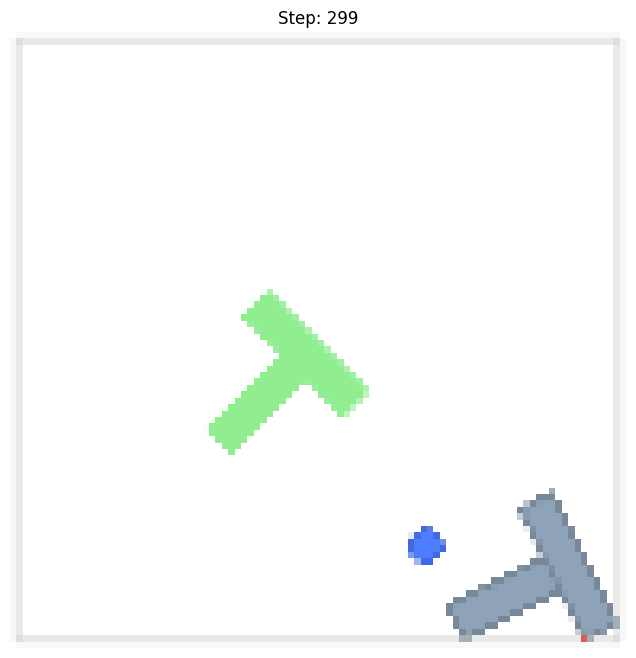

<Figure size 800x800 with 0 Axes>

In [6]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import time

print("Visualizing first episode...")
plt.figure(figsize=(8, 8))
for frame_idx in range(0, len(frames_for_video)):
    image = frames_for_video[frame_idx]
    # Display every frame slowly
    clear_output(wait=True)
    plt.clf()
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Step: {frame_idx}')
    display(plt.gcf())
    # Add delay to slow down the rendering (adjust this value as needed)
    time.sleep(0.01)  # 0.1 seconds = 10 FPS, increase for slower rendering
plt.clf()
env.close()

## 9. Mess things around

In [1]:
from pathlib import Path
import torch
from lerobot.datasets.lerobot_dataset import LeRobotDataset, LeRobotDatasetMetadata
from lerobot.configs.types import FeatureType
from lerobot.datasets.utils import dataset_to_policy_features
from lerobot.policies.pi05.modeling_pi05 import PI05Policy
from lerobot.policies.factory import make_pre_post_processors

# Check for GPU availability
assert torch.cuda.is_available(), "No GPU available. SmolVLA requires CUDA."
device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

# Prepare input/output features for the policy
dataset_metadata = LeRobotDatasetMetadata("lerobot/pusht")
features = dataset_to_policy_features(dataset_metadata.features)
output_features = {key: ft for key, ft in features.items() if ft.type is FeatureType.ACTION}
input_features = {key: ft for key, ft in features.items() if key not in output_features}

print("Input features:", list(input_features.keys()))
print("Output features:", list(output_features.keys()))

Using device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
Input features: ['observation.image', 'observation.state']
Output features: ['action']


In [3]:
from lerobot.policies.pi05.configuration_pi05 import PI05Config

cfg = PI05Config(
    input_features=input_features,
    output_features=output_features,
    device="cuda",
    paligemma_variant = "gemma_300m",
    action_expert_variant = "gemma_300m",
   
)

# Create pre/post processors
preprocessor, postprocessor = make_pre_post_processors(cfg, dataset_stats=dataset_metadata.stats)

# Another policy-dataset interaction is with the delta_timestamps. Each policy expects a given number frames
# which can differ for inputs, outputs and rewards (if there are some).
delta_timestamps = {
    "observation.image": [0.0],
    "observation.state": [0.0],
    "action": [i / dataset_metadata.fps for i in cfg.action_delta_indices],
}
# Load dataset with temporal configuration
dataset = LeRobotDataset(
    "lerobot/pusht",
    delta_timestamps=delta_timestamps,
)

print(f"Dataset loaded with {dataset.num_frames} frames")

dataloader = torch.utils.data.DataLoader(
    dataset,
    num_workers=0,
    batch_size=7,
    shuffle=False,
    pin_memory=True,
    drop_last=True,
)

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='torchvision.io._video_deprecation_warning')

example_data = next(iter(dataloader))
for key, value in example_data.items():
    print(key, value.shape if isinstance(value, torch.Tensor) else value)


batch = preprocessor(example_data)

Dataset loaded with 25650 frames
observation.image torch.Size([7, 3, 96, 96])
observation.state torch.Size([7, 1, 2])
action torch.Size([7, 50, 2])
episode_index torch.Size([7])
frame_index torch.Size([7])
timestamp torch.Size([7])
next.reward torch.Size([7])
next.done torch.Size([7])
next.success torch.Size([7])
index torch.Size([7])
task_index torch.Size([7])
observation.image_is_pad torch.Size([7, 1])
observation.state_is_pad torch.Size([7, 1])
action_is_pad torch.Size([7, 50])
task ['Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.', 'Push the T-shaped block onto the T-shaped target.']


In [4]:
for key, value in batch.items():
    print(key, value.shape if isinstance(value, torch.Tensor) else value)

action torch.Size([7, 50, 2])
next.reward torch.Size([7])
next.done torch.Size([7])
next.truncated False
info {}
observation.image_is_pad torch.Size([7, 1])
observation.state_is_pad torch.Size([7, 1])
action_is_pad torch.Size([7, 50])
task ['Task: Push the T-shaped block onto the T-shaped target., State: [112  -1 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128\n 128 128 128 128 128 128 128 128 128 128 128 128 128 128];\nAction: ', 'Task: Push the T-shaped block onto the T-shaped target., State: [115  -1 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128\n 128 128 128 128 128 128 128 128 128 128 128 128 128 128];\nAction: ', 'Task: Push the T-shaped block onto the T-shaped target., State: [117  -1 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128 128\n 128 128 128 128 128 128 128 128 128 128 128 128 128 128];\nAction: ', 'Task: Push the T-shaped block onto the T-shaped target., State: [118  -1 128 128 128 128 128 128 128 128 128 128 128 128 128 128

In [9]:
import importlib


# Reload the module
from lerobot.policies.pi05 import modeling_pi05
importlib.reload(modeling_pi05)

from lerobot.policies.pi05.modeling_pi05 import PI05Policy
cfg.debug_mode = True

cfg.debug_mode = True
policy = PI05Policy(cfg)

print(f"Number of trainable parameters: {sum(p.numel() for p in policy.parameters() if p.requires_grad):,}")

policy.train()
policy.to(device)
loss, _ = policy.forward(batch)

Number of trainable parameters: 1,683,014,416
x_t.shape torch.Size([7, 50, 32])
u_t.shape torch.Size([7, 50, 32])
time_expanded.shape torch.Size([7, 1, 1])
noise.shape torch.Size([7, 50, 32])
actions.shape torch.Size([7, 50, 32])
time.shape torch.Size([7])


RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2048 but got size 1024 for tensor number 1 in the list.

In [ ]:
actions = policy.select_action(batch)
print("actions.shape: ", actions.shape)

actions.shape:  torch.Size([2, 2])
